# Performant Python

In [1]:
import math
from PIL import Image
import array
import time
import numpy as np
import matplotlib.pyplot as plt

## Profiling
We compute the [Julia set](https://en.wikipedia.org/wiki/Julia_set) as an example to show how to profile a Python process. The Julia set is based on the recursive function
$$f(z) = z^2 + c$$
where z is a complex variable and c a constant.

In [30]:
z = -1.8 -1.8j
print(abs(z))

2.545584412271571


We set a starting point $z_0$ in the complex plane

We compute *f(z)* recursively by assigning its value to z for the next iteration. 

In [124]:
def f(z, c, num_iterations):
    f = []
    for i in range(num_iterations):
        z = z * z + c
        f.append(abs(z))
    return f

In [125]:
c = -0.62772 - 0.42193j
z1 = 0 + 0j
z2 = 0.802886 + 0j

In [126]:
num_iterations = 50
f1 = f(z1, c, num_iterations)
f2 = f(z2, c, num_iterations)

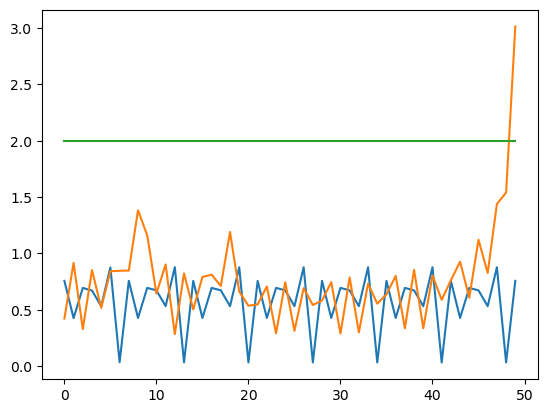

In [127]:
x = np.arange(0, num_iterations)
c = np.zeros(num_iterations) + 2.0
plt.plot(x, f1)
plt.plot(x, f2)
plt.plot(x, c)

## The Julia set
The value can increase to infinity or get closer to a point in the complex space called actractor. The attractors are white colored while the points that go to infinity are shown as black.

In [17]:
# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193

In [11]:
def show_greyscale(output_raw, width, height, max_iterations):
    """Convert list to array, show using PIL"""
    # convert our output to PIL-compatible input
    # scale to [0...255]
    max_iterations = float(max(output_raw))
    print(max_iterations)
    scale_factor = float(max_iterations)
    scaled = [int(o / scale_factor * 255) for o in output_raw]
    output = array.array('B', scaled)  # array of unsigned ints
    # display with PIL
    im = Image.new("L", (width, width))
    # EXPLAIN RAW L 0 -1
    im.frombytes(output.tobytes(), "raw", "L", 0, -1)
    im.show()

In [12]:
def show_false_greyscale(output_raw, width, height, max_iterations):
    """Convert list to array, show using PIL"""
    # convert our output to PIL-compatible input
    assert width * height == len(output_raw)  # sanity check our 1D array and desired 2D form
    # rescale output_raw to be in the inclusive range [0..255]
    max_value = float(max(output_raw))
    output_raw_limited = [int(float(o) / max_value * 255) for o in output_raw]
    # create a slightly fancy colour map that shows colour changes with
    # increased contrast (thanks to John Montgomery)
    output_rgb = ((o + (256 * o) + (256 ** 2) * o) * 16 for o in output_raw_limited)  # fancier
    output_rgb = array.array('I', output_rgb)  # array of unsigned ints (size is platform specific)
    # display with PIL/pillow
    im = Image.new("RGB", (width, height))
    # EXPLAIN RGBX L 0 -1
    im.frombytes(output_rgb.tobytes(), "raw", "RGBX", 0, -1)
    im.show()

In [13]:
def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output

In [27]:
def calc_pure_python(draw_output, desired_width, max_iterations):
    """Create a list of complex co-ordinates (zs) and complex parameters (cs), build Julia set and display"""
    x_step = (x2 - x1) / desired_width
    y_step = (y1 - y2) / desired_width
    x = []
    y = []
    ycoord = y2
    while ycoord > y1:
        y.append(ycoord)
        ycoord += y_step
    xcoord = x1
    while xcoord < x2:
        x.append(xcoord)
        xcoord += x_step
    # set width and height to the generated pixel counts, rather than the
    # pre-rounding desired width and height
    width = len(x)
    height = len(y)
    # build a list of co-ordinates and the initial condition for each cell.
    # Note that our initial condition is a constant and could easily be removed,
    # we use it to simulate a real-world scenario with several inputs to our function
    zs = []
    cs = []
    for ycoord in y:
        for xcoord in x:
            zs.append(complex(xcoord, ycoord))
            cs.append(complex(c_real, c_imag))

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    assert sum(output) == 33219980  # this sum is expected for 1000^2 grid with 300 iterations

    if draw_output:
        show_false_greyscale(output, width, height, max_iterations)
        #show_greyscale(output, width, height, max_iterations)

In [28]:
if __name__ == "__main__":
    # Calculate the Julia set using a pure Python solution with
    # reasonable defaults for a laptop
    # set draw_output to True to use PIL to draw an image
    calc_pure_python(draw_output=True, desired_width=1000, max_iterations=300)

Length of x: 1000
Total elements: 1000000
calculate_z_serial_purepython took 17.574941396713257 seconds
